# Simulation Overview

This document provides an overview of a Federated Learning (FL) simulation. The simulation includes 10 rounds, involves 30 clients, and utilizes the Federated Averaging (FedAvg) algorithm. The clients are grouped into different federations based on user criteria.

## Key Details

- **Number of Rounds:** 9
- **Number of Clients:** 30
- **Algorithm Used:** Federated Averaging (FedAvg)
- **Federations:** Grouped based on user criteria

## Description

The simulation is designed to illustrate the implementation and performance of a Federated Learning model using the FedAvg algorithm across multiple federations. Each federation represents a subset of the total clients, grouped according to specific user-defined characteristics. The process can be broken down as follows:

### Initialization

1. **Client Distribution:** The 30 clients are divided into various federations based on predefined criteria.
2. **Model Initialization:** A global model is initialized and shared with all clients.

### Federated Learning Process
- **Local Training:** Each client trains the model locally on its own data.
- **Model Updates:** After local training, clients send their model updates to their respective federation.
- **Aggregation:** Within each federation, local updates are aggregated using the FedAvg algorithm to create a federation model.
- **Global Aggregation:** Federation models are further aggregated to update the global model.
- **Model Distribution:** The updated global model is distributed back to all clients for the next round of local training.

This process is made 9 times, one for each round, in order to maximize the accuracy

### Evaluation

- **Performance Metrics:** The performance of the global model is evaluated at the end of each round using relevant metrics (e.g., accuracy, loss).
- **Convergence:** The simulation continues until the model performance stabilizes or the predefined number of rounds is reached.

## Conclusion

This simulation demonstrates the dynamics of Federated Learning with multiple federations using the FedAvg algorithm. By grouping clients into federations based on user criteria, the simulation aims to enhance the efficiency and performance of the learning process.


In [42]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
VERBOSE = 0
NUM_CLIENTS = 30

# folder dataset
PATH_TRAIN_X = "../UCI_HAR_Dataset/train/X_train.txt"
PATH_TRAIN_Y = "../UCI_HAR_Dataset/train/y_train.txt"

PATH_TEST_X = "../UCI_HAR_Dataset/test/X_test.txt"
PATH_TEST_Y = "../UCI_HAR_Dataset/test/y_test.txt"

PATH_TRAIN_SBJ = "../UCI_HAR_Dataset/train/subject_train.txt"
PATH_TEST_SBJ = "../UCI_HAR_Dataset/test/subject_test.txt"
PATH_FT = "../UCI_HAR_Dataset/features.txt"

features = pd.read_csv(PATH_FT, sep=" ", header=None, index_col=0).reset_index()

# training X
df_x_train = pd.read_fwf(PATH_TRAIN_X, header=None)
df_x_train.rename(columns=features[1], inplace=True)

# activity subject (train)
df_sbj_train = pd.read_csv(PATH_TRAIN_SBJ, sep=" ", header=None)
df_x_train['user'] = df_sbj_train.values
arr_sbj_train = (df_sbj_train.iloc[:,0]).to_list()
# training Y
y_train_col = pd.read_fwf(PATH_TRAIN_Y, header=None)

# testing X
df_x_test = pd.read_fwf(PATH_TEST_X, header=None)
df_x_test.rename(columns=features[1], inplace=True)
# activity subject (test)
df_sbj_test = pd.read_csv(PATH_TEST_SBJ, sep=" ", header=None)
df_x_test['user'] = df_sbj_test.values
arr_sbj_test = (df_sbj_test.iloc[:,0]).to_list()
# testing Y
y_test_col = pd.read_fwf(PATH_TEST_Y, header=None)

In [3]:
def get_model():
    # model definition
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(features.shape[0],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [4]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, X_test, y_train, y_test) -> None:
        super().__init__()
        # Create model
        self.model = get_model()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=3, batch_size=32, verbose=VERBOSE)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": float(accuracy)}

In [5]:
def get_client_fn():

    def client_fn(cid) -> fl.client.Client:
        cid = int(cid) + 1

        usr_act_train = []                              # activity made by user (train)
        usr_act_test = []                               # activity made by user (test)

        for i in range(len(arr_sbj_train)):
            if(arr_sbj_train[i] == cid):
                usr_act_train.append(i)
        
        for i in range(len(arr_sbj_test)):
            if(arr_sbj_test[i] == cid):
                usr_act_test.append(i)
        
        df_ext_train = pd.DataFrame(dtype=float)
        df_ext_test = pd.DataFrame(dtype=float)
        y_ext_train = pd.DataFrame(dtype=float)
        y_ext_test = pd.DataFrame(dtype=float)

        for i in range(len(usr_act_train)):
            index = usr_act_train[i]
            x_row = df_x_train.iloc[index,:561]
            df_ext_train = pd.concat([df_ext_train, x_row], ignore_index=True, axis=1)
            y_row = y_train_col.iloc[index]
            y_ext_train = pd.concat([y_ext_train, y_row], ignore_index=True, axis=1)

        for i in range(len(usr_act_test)):
            index = usr_act_test[i]
            x_row = df_x_test.iloc[index,:561]
            df_ext_test = pd.concat([df_ext_test, x_row], ignore_index=True, axis=1)
            y_row = y_test_col.iloc[index]
            y_ext_test = pd.concat([y_ext_test, y_row], ignore_index=True, axis=1)

        df_ext_train = df_ext_train.T
        y_ext_train = y_ext_train.T
        df_ext_test = df_ext_test.T
        y_ext_test = y_ext_test.T

        X_train = np.array(df_ext_train)
        y_train = np.array(y_ext_train)
        X_test = np.array(df_ext_test)
        y_test = np.array(y_ext_test)

        if (len(y_train) == 0) | (len(y_test) == 0):
            if (len(y_train) == 0) & (len(y_test) == 0):
                X_train, X_test, y_train, y_test = np.array()
            else:
                if (len(y_train) == 0):
                    X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.3)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.3)
        

        # Create and return client
        return FlowerClient(X_train, X_test, y_train, y_test).to_client()

    return client_fn


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


def get_evaluate_fn(X_test, y_test):
    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        return loss, {"accuracy": accuracy}

    return evaluate

In [6]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Create FedAvg strategy
myStrategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,                   # Sample 10% of available clients for training
    fraction_evaluate=0.05,             # Sample 5% of available clients for evaluation
    min_fit_clients=10,                  # Never sample less than 3 clients for training
    min_evaluate_clients=10,             # Never sample less than 3 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS
    ),                                  # Wait until at least 30 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    # evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.5, "num_gpus": 0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=9),
    strategy=myStrategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO :      Starting Flower simulation, config: num_rounds=9, no round_timeout
2024-07-10 21:23:51,775	INFO worker.py:1762 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 2795107124.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 1397553561.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 0.5, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=2013) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, p

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4598 - loss: 1.2551  


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=2007) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 21x across cluster]
(ClientAppActor pid=2007)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 21x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7201 - loss: 0.8547  [repeated 19x across cluster]


(ClientAppActor pid=2008) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 9x across cluster]
(ClientAppActor pid=2008)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 9x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8385 - loss: 0.5624  [repeated 10x across cluster]


(ClientAppActor pid=2008) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=2008)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]
(ClientAppActor pid=2004) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 7x across cluster]
(ClientAppActor pid=2004)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 7x across cluster]
INFO :      aggregate_fit: received 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8276 - loss: 0.6529 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.3528 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=2009) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=2009)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9033 - loss: 0.2389  [repeated 9x across cluster]


(ClientAppActor pid=2009) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 5x across cluster]
(ClientAppActor pid=2009)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 5x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5625 - loss: 0.8005
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7758 - loss: 0.7331  [repeated 2x across cluster]
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6016 - loss: 0.7564 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6296 - loss: 0.7357


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=2008) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 15x across cluster]
(ClientAppActor pid=2008)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 15x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=2006) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8262 - loss: 0.4007  [repeated 7x across cluster]


(ClientAppActor pid=2008) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x17a241440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7188 - loss: 0.4629
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7632 - loss: 0.3942 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
(ClientAppActor pid=2010) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 19x across cluster]
(ClientAppActor pid=2010)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 19x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8614 - loss: 0.3548  [repeated 9x across cluster]
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9053 - loss: 0.2019
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9099 - loss: 0.2404  [repeated 2x across cluster]


(ClientAppActor pid=2007) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 5x across cluster]
(ClientAppActor pid=2007)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 5x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9062 - loss: 0.1860
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9166 - loss: 0.1910 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7081 - loss: 1.2449  [repeated 6x across cluster]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8289 - loss: 0.3069


(ClientAppActor pid=2011) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 18x across cluster]
(ClientAppActor pid=2011)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 18x across cluster]


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8438 - loss: 0.3510
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9375 - loss: 0.2094
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9329 - loss: 0.2004  


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 30)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 30)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8625 - loss: 0.2678 [repeated 8x across cluster]


(ClientAppActor pid=2005) /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 20x across cluster]
(ClientAppActor pid=2005)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) [repeated 20x across cluster]
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 9 round(s) in 78.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.2059762147141666
INFO :      		round 2: 0.8443187867023259
INFO :      		round 3: 0.509544895446153
INFO :      		round 4: 0.5016886156684948
INFO :      		round 5: 0.5181920001037766
INFO :      		round 6: 0.42858936485470145
INFO :      		round 7: 0.40039748651860607
INFO :      		round 8: 0.4029048

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8773 - loss: 0.2641 


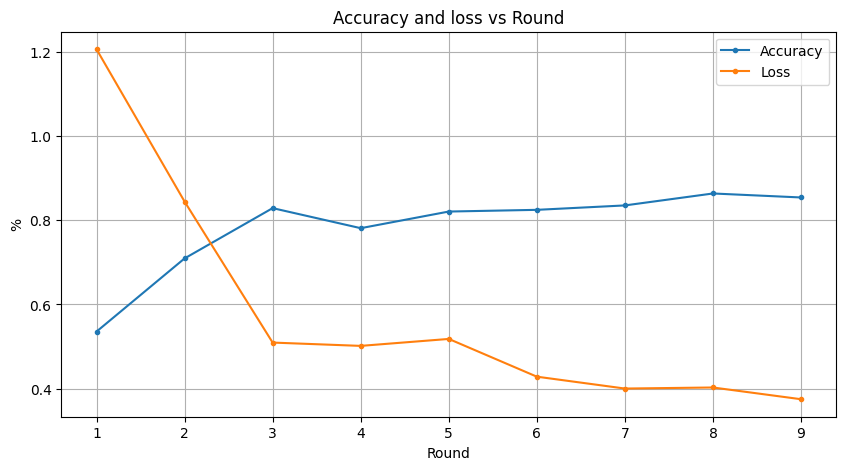

In [54]:
acc = pd.DataFrame(history.metrics_distributed["accuracy"])
loss = pd.DataFrame(history.losses_distributed)

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc[0], acc[1], marker='.', label='Accuracy')
plt.plot(loss[0], loss[1], marker='.', label='Loss')
plt.xlabel('Round')
plt.ylabel('%')
plt.title('Accuracy and loss vs Round')
plt.grid(True)
plt.legend()
plt.show()